# Training by using the derivative of multihead coherent state generation by pullback and a phase modulator

Use the multihead (2-head) gates in the phase space 
to create a network that represent a coherent state,
by starting from a Gaussian state and making a pullback

Use the derivative for the training


NOTE: remember to shut down the kernel when out of memory

<img src="../img/phasemodulator.png" width="900" height="200" />

<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 27 sep 2020<br>
@version 15 may 2023

In [1]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-05-14 11:18:09.681391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-14 11:18:09.681414: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float32

Precision for output on the screen

In [3]:
np.set_printoptions(precision=2)

## Dimension

In [4]:
N = 10

## Build vacuum by the Gaussian state

In [5]:
vacuum = ps.VacuumLayer(N)

2023-05-14 11:18:12.152434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-14 11:18:12.152477: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-14 11:18:12.152520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2023-05-14 11:18:12.153298: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build the pullback layer for generating the input coherent state

### Target displacement vector 
The displacement vector is a normalized column vector

In [6]:
dinput = 3.0*np.ones((N,1)); 
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())

[[0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32]]


Check the normalization of the dtarget

In [7]:
print(np.dot(dinput.transpose(), dinput)) 

[[1.]]


### Build the linear layer
The layer is a constant layer, as no training is needed

In [8]:
D = ps.DisplacementLayerConstant(dinput)

## Define the layer for the complex medium
The LinearConstantMultiHead generate by default a random medium with 
the relevant symplectic operator

In [9]:
R = ps.RandomLayerConstant(N)

## Define the trainable Phase Modulator layer

In [10]:
PM_train = ps.PhaseModulatorLayer(N)

### plot the matrix of the theta (initially random)

In [11]:
tf.print(tf.linalg.diag(PM_train.theta))

[[0.0434630327 0 0 0 0]
 [0 0.755655766 0 0 0]
 [0 0 0.253442585 0 0]
 [0 0 0 0.116642311 0]
 [0 0 0 0 0.50379163]]


### plot the symplectic matrix

In [12]:
M, _ ,_, _ = PM_train.get_M(); print(M)

tf.Tensor(
[[ 1.   -0.04  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.04  1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.73 -0.69  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.69  0.73  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.97 -0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.25  0.97  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.99 -0.12  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.12  0.99  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.88 -0.48]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.48  0.88]], shape=(10, 10), dtype=float32)


## Define the normalized target displacement vector

In [13]:
dtarget = np.zeros((N,1)); dtarget[0]=1.0; dtarget[1]=0.5;
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm

## Connect the layers

In [14]:
xin = tf.keras.layers.Input(N);
x3, a3 = R(xin)
x2, a2 = PM_train(x3,a3)
x1, a1 = D(x2,a2)
chir, chii = vacuum(x1, a1) 
pullback = tf.keras.Model(inputs = xin, outputs=[chir, chii])
# Add the derivative layer
der_layer = ps.meanRLayer(N)
Re = der_layer(chir,chii, pullback)
pullback_der = tf.keras.Model(inputs = xin, outputs=Re)

### Store the M,d of the LL_complex layer for later chek

In [15]:
M_R_tf, _=R.get_M(); M_R=M_R_tf.numpy()

In [16]:
d_R=R.d.numpy()

### Store the M, d of the untrained U_train layer for later check

In [17]:
theta_untrained_PM = PM_train.theta.numpy()

## Build the training set by using a target characteristic function

Number of training points
Also a single training point is enough for Gaussian state, more points improve the training

In [18]:
Nbatch = 100

Define the numpy function for the target characteristic function:
    a coherent state with a target displacement
One need a target d for any training points

In [19]:
xtrain = np.random.rand(Nbatch, N)-0.5
dtrain = np.zeros((Nbatch,N))
for j in range(Nbatch):
    for i in range(N):
        dtrain[j,i]=dtarget[i]

## Train the model

In [20]:
pullback_der.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

Summary of the derivative model

In [21]:
pullback_der.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 random_layer (RandomLayer)     [(None, 10),         50          ['input_1[0][0]']                
                                 (10, 1)]                                                         
                                                                                                  
 phase_modulator_layer (PhaseMo  [(None, 10),        5           ['random_layer[0][0]',           
 dulatorLayer)                   (10, 1)]                         'random_layer[0][1]']           
                                                                                            

Test the call of the derivative layer

In [22]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.44, 0.11, 0.25, 0.21, 0.32, 0.15, 0.59, 0.12, 0.36, 0.28]],
      dtype=float32)>

## Training of the model

In [23]:
history = pullback_der.fit(x=xtrain,
                      y=dtrain,
                      epochs=100,
                      verbose=2)

Epoch 1/100
4/4 - 1s - loss: 0.1111 - 933ms/epoch - 233ms/step
Epoch 2/100
4/4 - 0s - loss: 0.1070 - 5ms/epoch - 1ms/step
Epoch 3/100
4/4 - 0s - loss: 0.1030 - 5ms/epoch - 1ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0991 - 6ms/epoch - 2ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0953 - 5ms/epoch - 1ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0916 - 5ms/epoch - 1ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0881 - 5ms/epoch - 1ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0847 - 6ms/epoch - 2ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0813 - 6ms/epoch - 1ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0782 - 6ms/epoch - 2ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0751 - 7ms/epoch - 2ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0721 - 6ms/epoch - 1ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0692 - 6ms/epoch - 2ms/step
Epoch 14/100
4/4 - 0s - loss: 0.0665 - 6ms/epoch - 1ms/step
Epoch 15/100
4/4 - 0s - loss: 0.0638 - 6ms/epoch - 1ms/step
Epoch 16/100
4/4 - 0s - loss: 0.0612 - 6ms/epoch - 1ms/step
Epoch 17/100
4/4 - 0s - loss: 0.0586 - 6ms/ep

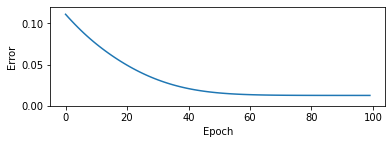

In [24]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.ylim(0,0.12)
plt.savefig('training_PM.pdf', bbox_inches='tight')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

In [25]:
x = tf.Variable(np.zeros((1,N)), dtype=tf_real) # the derivative are evaluated at x=0
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    chir, chii = pullback(x)

In [26]:
print(tape.gradient(chir,x))

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


In [27]:
print(tape.gradient(chii,x))

tf.Tensor([[ 0.84  0.42 -0.11 -0.04  0.09 -0.22  0.07  0.05 -0.08 -0.19]], shape=(1, 10), dtype=float32)


Use the derivative function for the derivative

Use the derivative model

In [28]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.84,  0.42, -0.11, -0.04,  0.09, -0.22,  0.07,  0.05, -0.08,
        -0.19]], dtype=float32)>

## Plot the model

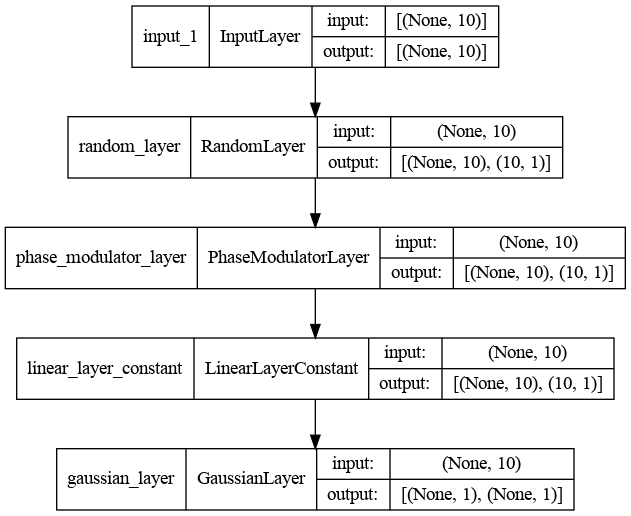

In [29]:
dot_img_file = 'PhaseModulator.png'
tf.keras.utils.plot_model(pullback, to_file=dot_img_file, show_shapes=True)

## Check the weights of the layers

### d and M of the complex layer LL_complex (these are unchanged)

In [30]:
print(R.d.numpy().transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [31]:
print(d_R.transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [32]:
M, _=R.get_M(); print(M.numpy())

[[ 0.37  0.17  0.39  0.29 -0.26  0.61  0.31 -0.17 -0.15 -0.12]
 [-0.17  0.37 -0.29  0.39 -0.61 -0.26  0.17  0.31  0.12 -0.15]
 [-0.41  0.11  0.55 -0.12 -0.02 -0.07  0.38  0.17  0.23  0.52]
 [-0.11 -0.41  0.12  0.55  0.07 -0.02 -0.17  0.38 -0.52  0.23]
 [-0.39  0.06 -0.22  0.4   0.57  0.29  0.27 -0.    0.28 -0.26]
 [-0.06 -0.39 -0.4  -0.22 -0.29  0.57  0.    0.27  0.26  0.28]
 [ 0.54  0.19 -0.34 -0.02  0.31 -0.15  0.47  0.25 -0.13  0.37]
 [-0.19  0.54  0.02 -0.34  0.15  0.31 -0.25  0.47 -0.37 -0.13]
 [ 0.4   0.07  0.27  0.21  0.15 -0.01 -0.43  0.4   0.59 -0.01]
 [-0.07  0.4  -0.21  0.27  0.01  0.15 -0.4  -0.43  0.01  0.59]]


In [33]:
print(M_R)

[[ 0.37  0.17  0.39  0.29 -0.26  0.61  0.31 -0.17 -0.15 -0.12]
 [-0.17  0.37 -0.29  0.39 -0.61 -0.26  0.17  0.31  0.12 -0.15]
 [-0.41  0.11  0.55 -0.12 -0.02 -0.07  0.38  0.17  0.23  0.52]
 [-0.11 -0.41  0.12  0.55  0.07 -0.02 -0.17  0.38 -0.52  0.23]
 [-0.39  0.06 -0.22  0.4   0.57  0.29  0.27 -0.    0.28 -0.26]
 [-0.06 -0.39 -0.4  -0.22 -0.29  0.57  0.    0.27  0.26  0.28]
 [ 0.54  0.19 -0.34 -0.02  0.31 -0.15  0.47  0.25 -0.13  0.37]
 [-0.19  0.54  0.02 -0.34  0.15  0.31 -0.25  0.47 -0.37 -0.13]
 [ 0.4   0.07  0.27  0.21  0.15 -0.01 -0.43  0.4   0.59 -0.01]
 [-0.07  0.4  -0.21  0.27  0.01  0.15 -0.4  -0.43  0.01  0.59]]


### d and M of the trained layer, before and after training (they must change)

In [34]:
PM_train.theta

<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=array([ 0.1 ,  0.32,  1.65, -0.82,  3.49], dtype=float32)>

In [35]:
theta_untrained_PM

array([0.04, 0.76, 0.25, 0.12, 0.5 ], dtype=float32)

# Retrieve the covariance matrix (must be a unitary matrix)

In [36]:
print(ps.covariance(N)(chir, chii, pullback))

(<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 1.00e+00, -5.96e-08,  5.96e-08,  9.69e-08,  1.19e-07,  1.79e-07,
         5.22e-08,  2.98e-08, -4.47e-08, -2.98e-08],
       [-0.00e+00,  1.00e+00, -2.24e-08,  1.19e-07, -7.45e-08,  8.94e-08,
        -5.59e-08,  5.59e-08,  7.45e-09,  1.49e-08],
       [ 1.49e-07, -3.73e-08,  1.00e+00,  1.49e-08,  5.22e-08,  3.73e-09,
        -1.68e-07, -2.42e-08,  6.89e-08,  1.04e-07],
       [ 4.47e-08,  7.08e-08,  8.38e-09,  1.00e+00, -9.31e-08,  5.40e-08,
         3.63e-08, -9.06e-08, -9.83e-08,  6.61e-08],
       [ 1.49e-07, -6.71e-08,  6.52e-08, -4.75e-08,  1.00e+00,  1.86e-08,
        -3.26e-08, -6.98e-08, -1.68e-08, -0.00e+00],
       [ 5.96e-08,  8.94e-08,  5.59e-08,  3.17e-08, -0.00e+00,  1.00e+00,
         7.45e-08, -2.24e-08,  3.73e-09,  4.47e-08],
       [-2.24e-08, -6.71e-08, -1.06e-07,  4.14e-08, -1.40e-08,  6.71e-08,
         1.00e+00, -6.52e-09, -2.42e-08,  5.59e-09],
       [-4.47e-08, -2.24e-08, -5.59e-09, -1.21e-07, -6.98e-0